In [1]:
%pip install sklearn-crfsuite


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.5 MB/s eta 0:00:00


In [2]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

import nltk
import sklearn_crfsuite
from sklearn_crfsuite import metrics

In [4]:
#Penn Treebank corpus
nltk.download('treebank')
corpus = nltk.corpus.treebank.tagged_sents()


[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!


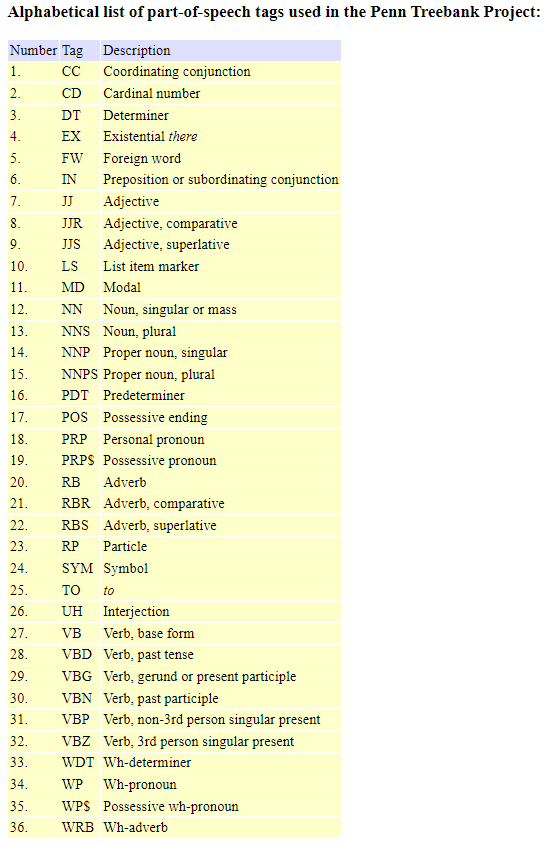

In [5]:
for element in corpus[:20]:
  print(element)

[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')]
[('Mr.', 'NNP'), ('Vinken', 'NNP'), ('is', 'VBZ'), ('chairman', 'NN'), ('of', 'IN'), ('Elsevier', 'NNP'), ('N.V.', 'NNP'), (',', ','), ('the', 'DT'), ('Dutch', 'NNP'), ('publishing', 'VBG'), ('group', 'NN'), ('.', '.')]
[('Rudolph', 'NNP'), ('Agnew', 'NNP'), (',', ','), ('55', 'CD'), ('years', 'NNS'), ('old', 'JJ'), ('and', 'CC'), ('former', 'JJ'), ('chairman', 'NN'), ('of', 'IN'), ('Consolidated', 'NNP'), ('Gold', 'NNP'), ('Fields', 'NNP'), ('PLC', 'NNP'), (',', ','), ('was', 'VBD'), ('named', 'VBN'), ('*-1', '-NONE-'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('of', 'IN'), ('this', 'DT'), ('British', 'JJ'), ('industrial', 'JJ'), ('conglomerate', 'NN'), ('.', '.')]
[('A', 'DT'), ('form'

In [6]:
def word_features(sentence, i):
    word = sentence[i][0]
    features = {
        'word': word,
        'is_first': i == 0, #первое слово
        'is_last': i == len(sentence) - 1,  #последнее слово
        'is_capitalized': word[0].upper() == word[0],
        'is_all_caps': word.upper() == word,      #верхний регистр
        'is_all_lower': word.lower() == word,      #нижний регистр
         #префикс
        'prefix-1': word[0],
        'prefix-2': word[:2],
        'prefix-3': word[:3],
         #суффикс
        'suffix-1': word[-1],
        'suffix-2': word[-2:],
        'suffix-3': word[-3:],
         #предыдущее слово
        'prev_word': '' if i == 0 else sentence[i-1][0],
         #следующее слово
        'next_word': '' if i == len(sentence)-1 else sentence[i+1][0],
        'has_hyphen': '-' in word,    #дефис
        'is_numeric': word.isdigit(),  #числительное
        'capitals_inside': word[1:].lower() != word[1:]
    }
    return features

In [50]:
# извлекаем характеристики для каждого предложения в корпусе
X = []
y = []
for sentence in corpus:
    X_sentence = []
    y_sentence = []
    for i in range(len(sentence)):
        X_sentence.append(word_features(sentence, i))
        y_sentence.append(sentence[i][1])
    X.append(X_sentence)
    y.append(y_sentence)


# разделяем на тест и трейн
split = int(0.8 * len(X))
X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]

In [91]:
# обучаем модель CRF
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

# Оцениваем на тестовых данных
y_pred = crf.predict(X_test)

print(metrics.flat_accuracy_score(y_test, y_pred))

0.9632716203403363


In [14]:
labels = list(crf.classes_)

In [17]:
metrics.flat_f1_score(y_test, y_pred,
                      average='weighted', labels=labels)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


0.9628714190434243

In [98]:
from sklearn_crfsuite.utils import flatten
from sklearn import metrics as skmetrics

y_test_flat = flatten(y_test)
y_pred_flat = flatten(y_pred)

print(skmetrics.classification_report(y_test_flat, y_pred_flat, labels = labels))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

              precision    recall  f1-score   support

         NNP       0.95      0.95      0.95      1800
           ,       1.00      1.00      1.00       930
          CD       1.00      1.00      1.00      1032
         NNS       0.94      0.99      0.96      1127
          JJ       0.85      0.91      0.88      1087
          MD       1.00      1.00      1.00       204
          VB       0.95      0.94      0.94       498
          DT       0.99      0.99      0.99      1611
          NN       0.96      0.94      0.95      2901
          IN       0.97      0.98      0.98      1952
           .       1.00      1.00      1.00       762
         VBZ       0.96      0.93      0.94       324
         VBG       0.94      0.92      0.93       261
          CC       1.00      1.00      1.00       429
         VBD       0.95      0.95      0.95       743
         VBN       0.93      0.90      0.91       452
      -NONE-       1.00      1.00      1.00      1340
          RB       0.92    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------------------------